In [100]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.signal as sig
import os
from itertools import groupby
import seawater as sw
import gsw

In [101]:
dataDirectory = '/Users/edwardlrichards/Documents/data/KAM11/enviornment/CTD/shipsCTD'
saveName = '/Users/edwardlrichards/cir_processing/Enviornment/processedData/shipsCTDs.pic'
ctd_files = os.listdir(dataDirectory)
ctdData = None

# Filter used to detect upcast or downcast
N=512
Fc=0.001
Fs=1
h=sig.firwin(numtaps=N, cutoff=Fc, nyq=Fs/2)
castIndex = 1
for i, file in enumerate(ctd_files):
    
    fPath = os.path.join(dataDirectory, file)
    fileName, fileExtension = os.path.splitext(file)
    
    if fileExtension != '.cnv':
        continue
    with open(fPath) as f:
        for i, line in enumerate(f.readlines()):
            if line == '*END*\n':
                lineNumber = i
                break
                
    if file !='km1119_cast1SSPconv.cnv':
        data = pd.read_csv(fPath, skiprows=lineNumber+1, sep=r"\s+",\
                names=['db', 'S/m', 'PSU', 'C', castIndex,\
                'm', 'blah'], index_col='m')
    else:
        data = pd.read_csv(fPath, skiprows=lineNumber+1, sep=r"\s+",\
                names=['db', 'S/m', 'PSU', 'C', castIndex,\
                'avg m/s', 'm', 'blah'], index_col='m')
        
    # downcast detection, upcasts were not recorded
    eps = 0.0004
    y=sig.lfilter(h, 1.0, data.index)
    yDiff = np.diff(y)
    diffI = np.arange(yDiff.size)

    # Group casts by sign of depth derivative
    blocks = [list(g) for k, g in groupby(list(yDiff>eps))]
    
    blockI = 0
    longestBlock = 0
    currentI = 0
    for i, b in enumerate(blocks):
        if b[0] & (longestBlock < len(b)):
            longestBlock = len(b)
            blockI = i
            startIndex = currentI
        currentI += len(b)

#     plt.figure()
#     plt.plot(np.arange(data.index.size), data.index)
#     plt.plot(np.arange(data.index.size)[startIndex:(startIndex+longestBlock)],\
#              data.index[startIndex:(startIndex+longestBlock)],'r')
#     plt.title('ctd cast '+ fPath)

    data = data.iloc[startIndex:(startIndex+longestBlock), :]
    if ctdData is None:
        ctdData = data
    else:
        ctdData = pd.merge(ctdData, data, left_index=True,
                            right_index=True, how='outer')
    castIndex += 1
    break

In [102]:
ctdData.columns

Index(['db', 'S/m', 'PSU', 'C', 1, 'blah'], dtype='object')

In [103]:
ssp_calculated = sw.eos80.svel(ctdData['PSU'], ctdData['C'], ctdData['db'])

In [104]:
lon = -159

lat = 22
abSal = gsw.SA_from_SP(ctdData['PSU'], ctdData['db'], lon, lat)
conTemp = gsw.CT_from_t(abSal, ctdData['C'], ctdData['db'])
gsw_SSP = gsw.sound_speed(abSal, conTemp, ctdData['db'])

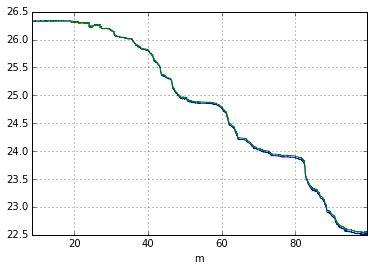

In [105]:
plt.plot(ctdData.index, conTemp)
ctdData['C'].plot()

(1530, 1540)

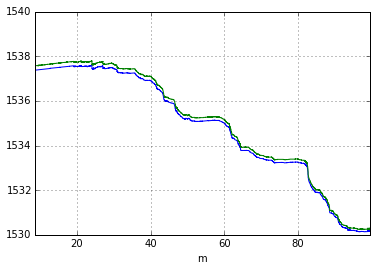

In [106]:
# plt.plot(ctdData.index, ssp_calculated)
plt.plot(ctdData.index, gsw_SSP)
ctdData[1].plot()
plt.ylim(1530, 1540)

In [107]:
np.max(np.abs(ctdData[1] - gsw_SSP))

0.20071836435135992

In [111]:
C=np.array([34.5487, 34.7275, 34.8605, 34.6810, 34.568, 34.56]) 
t=np.array([28.7856, 28.4329, 22.8103, 10.2600, 6.8863, 4.4036]) 
p=np.array([10., 50., 125., 250., 600., 1000.])

In [112]:
sw_SSP = sw.eos80.svel(C, t, p)

lon = 162.5
lat = 33
abSal = gsw.SA_from_SP(C, p, lon, lat)
conTemp = gsw.CT_from_t(abSal, t, p)
gsw_SSP = gsw.sound_speed(abSal, conTemp, p)


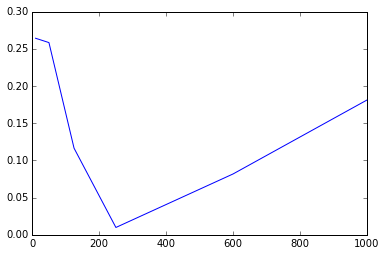

In [113]:
plt.plot(p, np.abs(gsw_SSP - sw_SSP))